In [ ]:
%%shell

wget "https://web.archive.org/web/20150918182409/http://www.cs.umd.edu/~sen/lbc-proj/data/cora.tgz"
tar -xzvf cora.tgz

pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
pip install torch-geometric

pip install networkx

pip install icecream
pip install tqdm

--2021-11-19 15:39:07--  https://web.archive.org/web/20150918182409/http://www.cs.umd.edu/~sen/lbc-proj/data/cora.tgz
Resolving web.archive.org (web.archive.org)... 207.241.237.3
Connecting to web.archive.org (web.archive.org)|207.241.237.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘cora.tgz.2’

cora.tgz.2              [  <=>               ] 163.15K   360KB/s    in 0.5s    

2021-11-19 15:39:08 (360 KB/s) - ‘cora.tgz.2’ saved [167063]

cora/
cora/README
cora/cora.content
cora/cora.cites
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cpu.html


In [ ]:
import numpy as np
import pandas as pd
import random
from icecream import ic

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric

import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

import networkx as nx

from tqdm.notebook import tqdm   

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20), dpi=80)


print("Torch version:", torch.__version__)
print("CUDA Present:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)

Torch version: 1.10.0+cu111
CUDA Present: False
CUDA Version: 11.1


<Figure size 1600x1600 with 0 Axes>

In [ ]:
CONFIG = {
    'PATH': './cora',
    'LIMIT': 500,
    'HIDDEN_CHANNELS': 1024,
    'NUM_LAYERS': 2,
    'DROPOUT_RATE': 0,
    'EPOCHS': 10
}

print("Here's the configuration: ")
for k, v in CONFIG.items():
    print(f"{k} = {v}")

Here's the configuration: 
PATH = ./cora
LIMIT = 250
HIDDEN_CHANNELS = 1024
NUM_LAYERS = 2
DROPOUT_RATE = 0
EPOCHS = 10


In [ ]:
class Data:
    def __init__(self, path):
        self.path = path
    
    def readFile(self, path):
        lines = []
        with open(path) as file:
            lines = file.readlines()
        return lines

    def readContent(self, data):
        nodes, labels, x = [], [], []
        for d in data:
            words = d.split("\t")
            nodes.append(words[0].strip())
            labels.append(words[-1].strip())
            x.append([ord(w) - 48 for w in words[1:-1]])
            # x.append(words[1:-1])

        # ic(x[0])
        LE = LabelEncoder()
        labels = LE.fit_transform(labels)
        ic(labels)
        x_req = torch.Tensor(x)
        # ic(x.shape)
        x = pd.DataFrame.from_records(x)
        
        return nodes, labels, LE, x_req, x

    def getLabels(self, LE, data):
        return LE.inverse_transform(data)

    def readCites(self, data):
        edges = []
        for d in data:
            words = d.split("\t")
            edges.append([
                words[0].strip(),
                words[1].strip()
            ])
        return edges

    def splitDataCount(self, data, labels):
        lcounter = dict((l, 0) for l in labels)
        indices = []
        for i in range(len(labels)):
            label = labels[i]
            if lcounter[label] < CONFIG['LIMIT']:
                indices.append(i)
                lcounter[label] += 1
        rest = [x for x in range(len(labels)) if x not in indices]
        # rest = random.sample(rest, 1000)
        indices = torch.LongTensor(indices)
        rest = torch.LongTensor(rest)
        return indices, rest

    def normalizeMatrix(self, A):
        return scipy.sparse.diags(np.array(A.sum(1)).flatten() ** -1).dot(A)

    def toTensor(self, A):
        A = A.tocoo()
        i = torch.tensor(np.vstack((A.row, A.col)), dtype=torch.long)
        v = torch.tensor(A.data, dtype=torch.float)
        return torch.sparse_coo_tensor(i, v, torch.Size(A.shape))

    def buildGraph(self):
        nodes, edges = self.getGraph()
        G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        A = nx.adjacency_matrix(G)
        I = scipy.sparse.identity(A.shape[0])
        A = A + I
        A = self.normalizeMatrix(A)
        A = self.toTensor(A)
        A = A.to_dense()
        ic(A.shape)
        ic(nx.info(G))
        return A, G

    def getIndices(self):
        return self.train, self.test

    def getGraph(self):
        return self.nodes, self.edges

    def getMatrix(self):
        return self.A

    def getXY(self):
        return self.x, torch.LongTensor(self.labels)

    def printData(self):
        print(f"Number of nodes: {len(self.nodes)}")
        print(f"Number of features per node: {len(self.x[0])}")
        print(f"Categories: {set(self.labels)}")

    def handle(self):
        data = self.readFile(self.path + '/cora.content')
        e_data = self.readFile(self.path + '/cora.cites')
        self.nodes, self.labels, self.LE, self.x, self.split = self.readContent(data)
        self.train, self.test = self.splitDataCount(self.split, self.labels)
        self.edges = self.readCites(e_data)
        self.A, self.G = self.buildGraph()

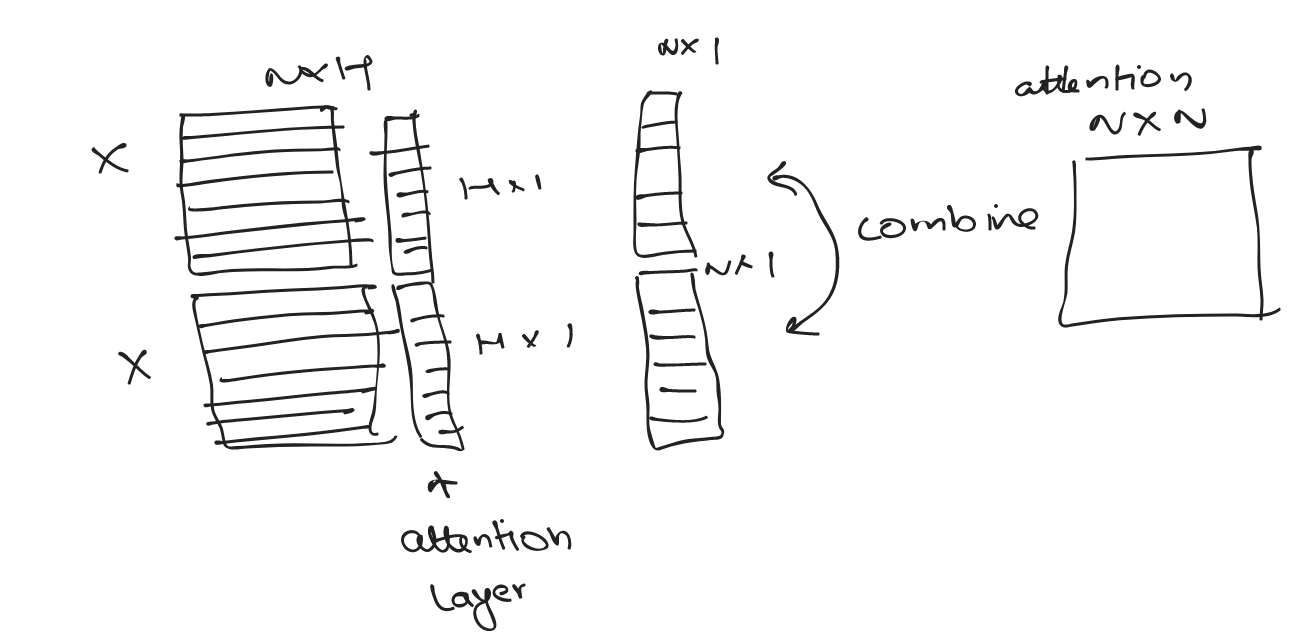

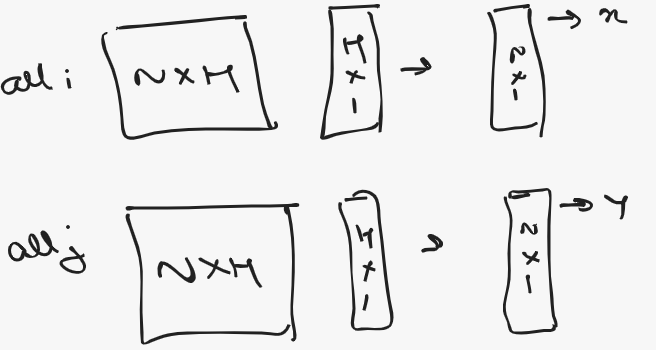

In [ ]:
class MyGATLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        in_channels: #features in the input
        out_channels: #features in the output
        these layers have their *own* independent weights and biases
        """
        super().__init__()
        self.out_channels = out_channels
        
        # W = FxH
        self.W = nn.Parameter(torch.empty(in_channels, out_channels))
        nn.init.xavier_uniform_(self.W, gain=1.414)

        # a = 2Hx1 (So its essentially concating features of 2 nodes)
        # Note: torch.empty does random assignments of value
        self.a = nn.Parameter(torch.empty(size=(2*out_channels, 1)))
        nn.init.xavier_uniform_(self.a, gain=1.414)
        self.leaky = nn.LeakyReLU()

        # for the attention visual
        # self.attention = None

    def forward(self, X, A):
        """
        does the neat math on *symmetrically normalized* A
        """

        # Normal feature calculation, Wh = NxH
        wh = torch.mm(X, self.W)

        # wh = NxH, a = 2Hx1, halfA = Hx1
        # both half = NxH * Hx1 = Nx1
        first_half = wh@self.a[self.out_channels:, :]
        second_half = wh@self.a[:self.out_channels, :]

        # NxN
        after = second_half + first_half.T
        after = self.leaky(after)
        neginf = 0*torch.ones_like(after)
        attention = torch.where(A>0, after, neginf)
        attention = F.softmax(attention, dim=1)
        hprime = torch.matmul(attention, wh)
        # ic(hprime.shape)

        # self.attention = attention
        return F.elu(hprime)

In [ ]:
class MyGAT(nn.Module):
    def __init__(
            self, 
            in_channels, 
            hidden_channels, 
            num_layers, 
            out_channels, 
            dropout_rate,
            attention_channels,
        ):
        super().__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.out_channels = out_channels
        self.dropout_rate = dropout_rate
        
        self.MyGATLayers = [
            MyGATLayer(self.in_channels, self.hidden_channels)
        ]
        for _ in range(1, self.num_layers):
            self.MyGATLayers.append(
                MyGATLayer(self.hidden_channels, self.hidden_channels)
            )        
        self.outputLayer = MyGATLayer(self.hidden_channels, self.out_channels)

    # def get_attention_matrices(self, yeet=False):
    #     attention_matrices = [
    #         layer.attention.detach().numpy() for layer in self.MyGATLayers
    #     ]
    #     if yeet: return attention_matrices
        
    #     I = np.eye(attention_matrices[0].shape[0], attention_matrices[0].shape[1])

    #     return [
    #         np.subtract(matrix, I) for matrix in attention_matrices
    #     ]
    
    def forward(self, X, A):
        """
        math done on *symmetrically normalized* A
        """
        for layer in self.MyGATLayers:
            X = layer.forward(X, A)

        X = F.relu(X)
        X = F.dropout(X, p=self.dropout_rate, training=self.training)
        X = self.outputLayer.forward(X, A)
        
        return F.log_softmax(X)

In [ ]:
dataset = Data(CONFIG['PATH'])
dataset.handle()
X, y = dataset.getXY()
train, test = dataset.getIndices()
ic(X.shape, y.shape)
ic(train.shape, test.shape)
A = dataset.getMatrix()

ic| labels: array([2, 5, 4, ..., 1, 0, 2])
ic| A.shape: torch.Size([2708, 2708])
ic| nx.info(G): 'Graph with 2708 nodes and 5278 edges'
ic| X.shape: torch.Size([2708, 1433]), y.shape: torch.Size([2708])
ic| train.shape: torch.Size([1647]), test.shape: torch.Size([1061])


In [ ]:
model = MyGAT(
    in_channels=X.shape[1],
    hidden_channels=CONFIG['HIDDEN_CHANNELS'],
    num_layers=CONFIG['NUM_LAYERS'],
    out_channels=7,
    dropout_rate=CONFIG['DROPOUT_RATE'],
    attention_channels=A.shape[1]
)

loss = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
losses = []
for _ in tqdm(range(CONFIG['EPOCHS'])):
    optimizer.zero_grad()
    output = model.forward(X, A)
    train_x = torch.index_select(output, 0, train)
    train_y = torch.index_select(y, 0, train)
    l = loss(train_x, train_y)
    l.backward()
    losses.append(l.item())
    optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
losses

[1.9482448101043701,
 1.9481967687606812,
 1.9434757232666016,
 1.9423068761825562,
 1.9452130794525146,
 1.9453544616699219,
 1.9431345462799072,
 1.9415209293365479,
 1.9412553310394287,
 1.9414817094802856]

In [ ]:
output = model.forward(X, A)
test_x = torch.index_select(output, 0, test)
test_y = torch.index_select(y, 0, test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
predictions = torch.argmax(test_x, dim=1)

In [ ]:
predictions, test_y = predictions.numpy(), test_y.numpy()

In [ ]:
acc = 0
for i in range(len(test_y)):
    if predictions[i] == test_y[i]:
        acc += 1
ic(acc/len(test_y)*100)

ic| acc/len(test_y)*100: 4.524033930254477


4.524033930254477

In [ ]:
def get_attention_matrices():    
    X, y = dataset.getXY()
    A = dataset.getMatrix()
    
    attention_matrices = None
    with torch.no_grad():
        attention_matrices = model.get_attention_matrices(yeet=True)
    return attention_matrices

attention_matrices = get_attention_matrices()

# DEBUGGING INFORMATION
# ic(X.shape)
# ic(A.shape)
# ic(output.shape)
# ic(len(attention_matrices))
# ic(attention_matrices[-1].shape)

In [ ]:
def get_class_rows(matrix, class_label=1):
    n = len(X)
    indices = [int(y[i] == class_label) for i in range(n)]
    return np.array(indices)

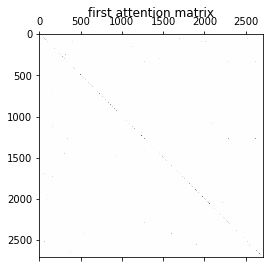

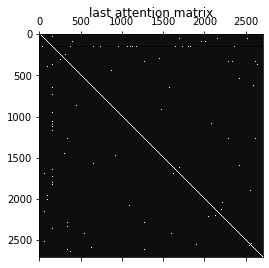

In [ ]:
def plot_matrix(matrix, label, filter_class=None):
    start_point_x, start_point_y = 420, 420
    end_point_x, end_point_y = 469, 469

    # plt.figure(figsize=(200, 200))

    if filter_class:
        indices = get_class_rows(matrix, filter_class)
        # print(indices)

        new_mat = []
        m, n = len(matrix), len(matrix[0])
        for i in range(m):
            if indices[i]:
                new_row = []
                for j in range(n):
                    if indices[j]: 
                        new_row.append(matrix[i][j])
                new_mat.append(np.array(new_row))
        matrix = np.array(new_mat)
    

    # matrix = normalize(matrix, axis=1)
    plt.matshow(matrix, cmap=plt.get_cmap("binary"))
    plt.title(label)
    # plt.legend()
    plt.show()

plot_matrix(attention_matrices[0], "first attention matrix")
plot_matrix(attention_matrices[-1], "last attention matrix")